In [ ]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [ ]:
# Defining the file path for the Excel dataset
file_path = "E-commerce_data.xlsx"

# Reading all sheets from the Excel file into a dictionary
# Each key represents a sheet name, and the corresponding value is a DataFrame
sheets_dict = pd.read_excel(file_path, sheet_name=None)

# Displaying the names of all sheets found in the Excel file
print("Sheets found:", sheets_dict.keys())

Sheets found: dict_keys(['customers', 'genders', 'cities', 'transactions', 'branches', 'merchants'])


In [ ]:
# Selecting the main sheet to work with
main_sheet_name = "customers"
main_df = sheets_dict[main_sheet_name]

# Iterating through all sheets in the Excel file
for sheet_name, df in sheets_dict.items():
    if sheet_name != main_sheet_name:  # Skipping the main sheet itself

        # Identifying common columns between the main DataFrame and the current sheet
        common_cols = list(set(main_df.columns) & set(df.columns))

        if common_cols:  # Proceed only if there are common columns
            print(f"Merging {sheet_name} using columns: {common_cols}")

            # Merging the current sheet's DataFrame into the main DataFrame using common columns
            main_df = main_df.merge(df, on=common_cols, how="left")

Merging genders using columns: ['gender_id']
Merging cities using columns: ['city_id']
Merging transactions using columns: ['customer_id']
Merging branches using columns: ['branch_id']
Merging merchants using columns: ['merchant_id']


In [ ]:
# Calculate the number of transactions for each customer
main_df['transaction_count'] = main_df.groupby('customer_id')['transaction_id'].transform('count')

# Calculate the average time between transactions for each customer
main_df['avg_time_between_transactions'] = main_df.groupby('customer_id')['transaction_date'].diff().dt.days.mean()

# Calculate the number of coupons used by each customer
main_df['coupons_burned'] = main_df.groupby('customer_id')['burn_date'].transform('count')

In [ ]:
# Encode categorical variables using one-hot encoding, dropping the first category to avoid multicollinearity
main_df = pd.get_dummies(main_df, columns=['gender_name', 'city_name'], drop_first=True)

In [ ]:
# Select features for clustering
features = ['transaction_count', 'avg_time_between_transactions', 'coupons_burned', 'gender_name_Male', 'city_name_Sohag']

# Create the feature set (X) from the selected columns
X = main_df[features]

In [ ]:
# Normalize the features using StandardScaler
scaler = StandardScaler()

# Apply the scaler to the features and transform them to have a mean of 0 and a standard deviation of 1
X_scaled = scaler.fit_transform(X)

In [ ]:
# Elbow method to determine the optimal number of clusters (k)
inertia = []  # List to store inertia values for different k values

# Iterate over a range of k values (from 2 to 10)
for k in range(2, 11):
    # Initialize KMeans with k clusters and a random seed for reproducibility
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Fit the KMeans model to the scaled features
    kmeans.fit(X_scaled)

    # Append the inertia (within-cluster sum of squared distances) to the inertia list
    inertia.append(kmeans.inertia_)

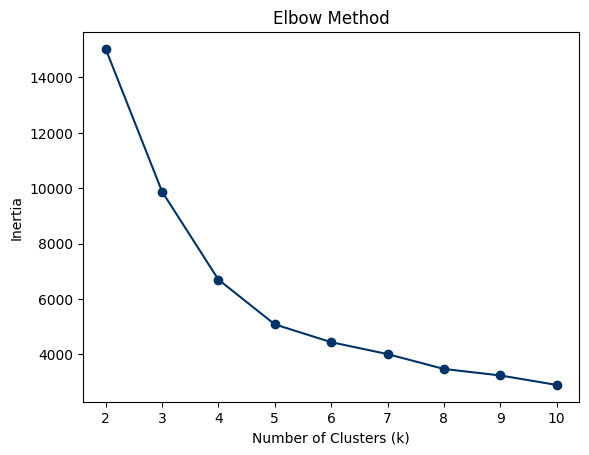

In [ ]:
# Plot the inertia values for different k values to visualize the Elbow Method
plt.plot(range(2, 11), inertia, marker='o', color='#003366')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [ ]:
# Train the K-Means model with the optimal number of clusters (k=4)
kmeans = KMeans(n_clusters=4, random_state=42)

# Assign each data point to a cluster and store the cluster labels in a new column 'cluster'
main_df['cluster'] = kmeans.fit_predict(X_scaled)

In [ ]:
# Evaluate the clustering performance using Silhouette Score
score = silhouette_score(X_scaled, main_df['cluster'])

# Print the Silhouette Score to assess the quality of the clustering
print(f'Silhouette Score: {score}')

Silhouette Score: 0.41743422840490185


In [ ]:
# Analyze the clusters by calculating the mean of selected features for each cluster
cluster_summary = main_df.groupby('cluster').agg({
    'transaction_count': 'mean',
    'coupons_burned': 'mean',
    'gender_name_Male': 'mean',
    'city_name_Sohag': 'mean'
})

# Print the summary statistics for each cluster
cluster_summary

,transaction_count,coupons_burned,gender_name_Male,city_name_Sohag
cluster,,,,
0,5.991071,3.084821,0.571429,1.0
1,5.285126,2.530108,0.000000,0.0
2,8.698976,4.878645,0.684791,0.0
3,4.911746,2.157460,1.000000,0.0


In [ ]:
# Analyze each cluster by calculating summary statistics for various features
cluster_summary = main_df.groupby('cluster').agg({
    'customer_id': 'count',
    'transaction_count': 'mean',
    'coupons_burned': 'mean',
    'gender_name_Male': 'mean',
    'city_name_Sohag': 'mean',
    'transaction_status': lambda x: (x == 'burned').mean()
}).reset_index()

# Rename the columns for better clarity
cluster_summary.rename(columns={
    'customer_id': 'total_customers',
    'transaction_count': 'avg_transactions',
    'coupons_burned': 'avg_coupons_burned',
    'gender_name_Male': 'male_ratio',
    'city_name_Sohag': 'sohag_ratio',
    'transaction_status': 'burned_transaction_ratio'
}, inplace=True)

# Print the updated summary with new column names
cluster_summary

,cluster,total_customers,avg_transactions,avg_coupons_burned,male_ratio,sohag_ratio,burned_transaction_ratio
0,0,224,5.991071,3.084821,0.571429,1.0,0.517857
1,1,1943,5.285126,2.530108,0.000000,0.0,0.487905
2,2,1269,8.698976,4.878645,0.684791,0.0,0.575256
3,3,1575,4.911746,2.157460,1.000000,0.0,0.458413


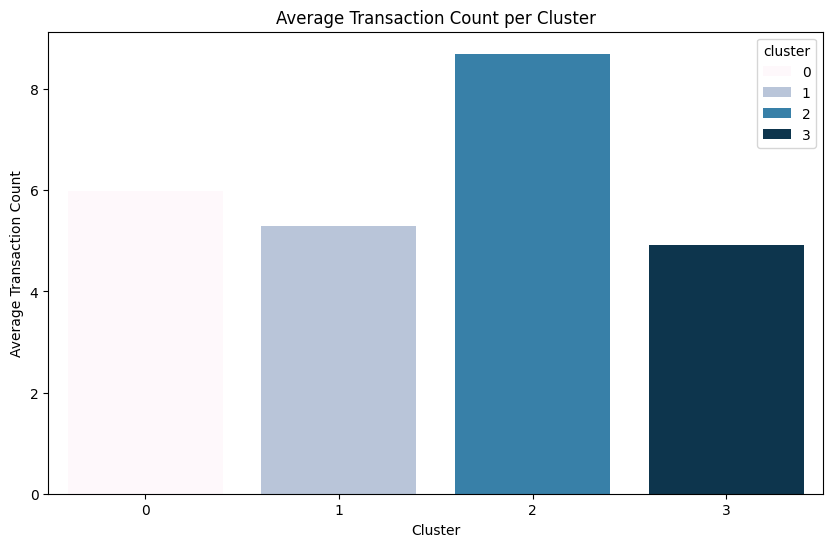

In [ ]:
# Create a bar plot to visualize the average transaction count per cluster
plt.figure(figsize=(10, 6))
sns.barplot(data=main_df, x='cluster', y='transaction_count', errorbar=None, hue='cluster', palette='PuBu', legend=True)
plt.title('Average Transaction Count per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Transaction Count')
plt.show()

- Cluster 2 (Average: 8.7 transactions):
  - This cluster exhibits the highest average transaction count, indicating that customers in this group are highly engaged with the system. They interact with the platform more frequently, suggesting a high level of activity and usage.

- Cluster 0 (Average: 5.99 transactions):
  - Customers in this cluster show a moderate level of engagement, with a balanced average transaction count. They interact consistently with the platform, though less frequently than Cluster 2, implying a steady but not overly frequent usage pattern.

- Cluster 1 (Average: 5.29 transactions):
  - This cluster demonstrates a relatively lower average transaction count compared to the other clusters. It suggests that customers in this group may not be as engaged or could be encountering barriers that prevent frequent interactions with the system.

- Cluster 3 (Average: 4.91 transactions):
  - Cluster 3 represents the least active group in terms of transaction frequency. These customers exhibit the lowest engagement levels, which could indicate challenges in user experience or a lack of incentives to encourage more frequent use.

In [ ]:
# Create a box plot with Plotly to visualize the distribution of transaction counts per cluster
fig = px.box(main_df,
             x='cluster',
             y='transaction_count',
             color='cluster',
             color_discrete_map={
                 0: '#9E9AC8',
                 1: '#6A6CC5',
                 2: '#4A69A1',
                 3: '#2E4D6D'
             },
             title='Distribution of Transaction Count per Cluster',
             labels={'cluster': 'Cluster', 'transaction_count': 'Transaction Count'})

# Show the plot
fig.show()

- Cluster 0:
  - Cluster 0 has a lower mean transaction count compared to others. The transaction counts range from 1 to 14, suggesting that there are some customers with a significantly higher number of transactions (outliers).
  - The median of 5 indicates that half of the customers in this cluster have transaction counts lower than 5, while the other half have more.

- Cluster 1:
  - has the second-lowest average transaction count and a relatively smaller spread compared to Cluster 0.
  - The majority of the customers in Cluster 1 have transaction counts around the median value of 5, and the range is limited between 0 and 9 transactions.
  - The standard deviation (1.62) is also lower, indicating that the transaction counts in this cluster are more tightly grouped around the median.

- Cluster 2:
  - has the highest mean transaction count, which indicates that these customers are the most active in terms of transactions.
  - The transaction counts are tightly clustered between 6 and 13, with a higher median value of 9. This suggests that most customers in this cluster are more consistent in their number of transactions.
  - The lower standard deviation (1.47) shows that the data is more concentrated around the mean, indicating less variability in this cluster.

- Cluster 3:
  - has the lowest mean transaction count and a similar spread to Cluster 1.
  - The range from 0 to 9 transactions indicates that there are a few customers with very low or no transactions, which is reflected in the lower average and median values.
  - Despite having a lower mean, the cluster has a spread of data with a relatively high standard deviation (1.68), showing some degree of variability in transaction counts.

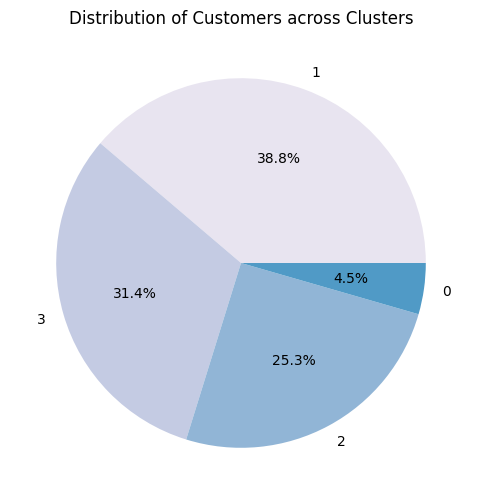

In [ ]:
# Calculate the count of customers in each cluster
cluster_counts = main_df['cluster'].value_counts()

# Create a pie chart to visualize the distribution of customers across clusters
plt.figure(figsize=(6, 6))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', colors=sns.color_palette('PuBu'))
plt.title('Distribution of Customers across Clusters')
plt.show()

- Cluster 1:
  - This cluster contains 1,943 customers, making it the largest cluster in terms of customer count. It represents the highest percentage of customers, accounting for around 41.2% of the total customer base. This suggests that this cluster may include the most active customers or those with specific characteristics that differentiate them from other clusters.

- Cluster 3:
  - This cluster has 1,575 customers, which is about 33.1% of the total. It represents the second-largest cluster, indicating that it also contains a significant portion of customers. This could suggest a group of customers with differing behaviors or characteristics compared to Cluster 1.

- Cluster 2:
  - With 1,269 customers, this cluster makes up approximately 26.4% of the total customer base. While it is smaller in size compared to the other two clusters, it still represents a significant portion of customers.

- Cluster 0:
  - This is the smallest cluster, containing only 224 customers, which accounts for less than 5% of the total customers.